# Rank the parameters for each model

In [1]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))

In [2]:
# find data set SVM did not finish on
svm_data = data[data['classifier']=='SVC']
print([problem for problem,d in data.groupby('dataset') if problem not in svm_data['dataset'].unique()])

print('number of data sets in svm_data:',len(svm_data['dataset'].unique()))
print('number of data sets:',len(data['dataset'].unique()))
print('svm missing ',[p for p in data['dataset'].unique() if p not in svm_data['dataset'].unique()])

[]
number of data sets in svm_data: 164
number of data sets: 164
svm missing  []


In [3]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

model_param_ranks = defaultdict(list)

for dataset, group_dataset in tqdm(data.groupby('dataset')):
    num_scores = float(len(group_dataset['accuracy'].unique()))
    accuracy_ranks = {}
    
    for rank, accuracy in enumerate(sorted(group_dataset['accuracy'].unique(), reverse=True)):
        accuracy_ranks[accuracy] = (rank + 1) / num_scores
    
    for index, row in group_dataset.iterrows():
        model_param_ranks['{}-{}'.format(row['classifier'],
                                         row['parameters'])].append(accuracy_ranks[row['accuracy']])

100%|██████████| 164/164 [08:46<00:00,  3.00s/it]


In [4]:
model_average_param_ranks = defaultdict(float)
for model_param in model_param_ranks:
    model_average_param_ranks[model_param] = np.mean(model_param_ranks[model_param])

## Best params for each model from rankings

In [5]:
models_seen = set()

for model_param in sorted(model_average_param_ranks, key=model_average_param_ranks.get, reverse=False):
    model = model_param.split('-')[0]
    if model not in models_seen:
        models_seen.add(model)
    else:
        continue

    print('{}\t{}'.format(round(model_average_param_ranks[model_param], 3), model_param))
    
    if len(models_seen) >= 15:
        break

0.081	XGBClassifier-n_estimators=500,learning_rate=0.01,gamma=0.45,max_depth=50,subsample=0.7000000000000001,seed=324089,nthread=1
0.092	RandomForestClassifier-n_estimators=500,min_impurity_decrease=0.0,max_features=sqrt,criterion=entropy,random_state=324089
0.097	GradientBoostingClassifier-n_estimators=500,min_impurity_decrease=0.005,max_features=sqrt,learning_rate=0.1,loss=deviance,random_state=324089
0.098	ExtraTreesClassifier-n_estimators=500,min_impurity_decrease=0.0,max_features=0.5,criterion=gini,random_state=324089
0.127	SVC-C=10.0,gamma=auto,kernel=poly,degree=2,coef0=0.5,random_state=324089
0.163	KNeighborsClassifier-n_neighbors=14,weights=distance
0.172	DecisionTreeClassifier-min_impurity_decrease=0.0,max_features=None,criterion=entropy,random_state=324089
0.184	LogisticRegression-C=2.0,penalty=l1,fit_intercept=True,dual=False,random_state=324089
0.188	LinearSVC-C=1.0,penalty=l1,fit_intercept=True,dual=False,random_state=324089
0.222	PassiveAggressiveClassifier-C=0.01,loss=s

## Average each model parameter's rankings

In [6]:
from collections import defaultdict
import numpy as np

model_param_breakdown_rankings = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for model_param in model_average_param_ranks:
    model = model_param.split('-')[0]
    if model == 'GaussianNB':
        continue
    params = '-'.join(model_param.split('-')[1:])
    params = params.split(',')
    rank = model_average_param_ranks[model_param]
    for param in params:
        model_param_breakdown_rankings[model][param.split('=')[0]][param.split('=')[-1]].append(rank)

model_param_breakdown_average_rankings = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

for model in sorted(model_param_breakdown_rankings):
    for param in model_param_breakdown_rankings[model]:
        for param_val in model_param_breakdown_rankings[model][param]:
            model_param_breakdown_average_rankings[model][param][param_val] = round(np.mean(
                model_param_breakdown_rankings[model][param][param_val]), 3)

In [7]:
for model in sorted(model_param_breakdown_average_rankings):
    print(model)
    print('--------------------')
    for param in model_param_breakdown_average_rankings[model]:
        print(param)
        for param_val in sorted(model_param_breakdown_average_rankings[model][param],
                                key=model_param_breakdown_average_rankings[model][param].get):
            print('\t={}{}{}'.format(param_val,
                                   (' ' * 25)[:25 - len(param_val)],
                                   model_param_breakdown_average_rankings[model][param][param_val]))
            
    print('')

AdaBoostClassifier
--------------------
learning_rate
	=0.5                      0.233
	=0.1                      0.246
	=1.0                      0.262
	=0.01                     0.287
	=50.0                     0.679
	=100.0                    0.709
	=10.0                     0.797
n_estimators
	=500                      0.447
	=100                      0.453
	=50                       0.458
	=10                       0.478
random_state
	=324089                   0.459

BernoulliNB
--------------------
alpha
	=10.0                     0.42
	=5.0                      0.422
	=25.0                     0.424
	=1.0                      0.429
	=0.75                     0.43
	=0.5                      0.431
	=50.0                     0.431
	=0.25                     0.432
	=0.1                      0.434
	=0.0                      0.438
fit_prior
	=True                     0.401
	=False                    0.457
binarize
	=0.5                      0.351
	=0.25                     0.363
	=0.7

# Rank each model on a per-data set basis

In [8]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))

In [9]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

model_ranks = defaultdict(list)

for dataset, group_dataset in tqdm(data.groupby('dataset')):
    if len(group_dataset['classifier'].unique()) != 14:
        continue
    
    num_scores = float(len(group_dataset['accuracy'].unique()))
    accuracy_ranks = {}
    
    for rank, accuracy in enumerate(sorted(group_dataset['accuracy'].unique(), reverse=True)):
        accuracy_ranks[accuracy] = (rank + 1) / num_scores
    
    for index, row in group_dataset.iterrows():
        model_ranks[row['classifier']].append(accuracy_ranks[row['accuracy']])

100%|██████████| 164/164 [07:13<00:00,  2.54s/it]


In [10]:
model_average_ranks = defaultdict(float)
for model in model_ranks:
    model_average_ranks[model] = np.mean(model_ranks[model])

In [11]:
for model in sorted(model_average_ranks, key=model_average_ranks.get, reverse=False):
    print('{}\t{}'.format(round(model_average_ranks[model], 3), model))

0.194	KNeighborsClassifier
0.22	LogisticRegression
0.223	LinearSVC
0.224	RandomForestClassifier
0.267	ExtraTreesClassifier
0.319	DecisionTreeClassifier
0.325	SVC
0.329	PassiveAggressiveClassifier
0.331	GaussianNB
0.336	XGBClassifier
0.372	GradientBoostingClassifier
0.373	MultinomialNB
0.429	BernoulliNB
0.459	AdaBoostClassifier


# How often is model X better than model Y?

In [39]:
import pandas as pd
import pdb

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['dataset','classifier'])['accuracy'].max().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
data.head()

,dataset,classifier,accuracy
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,0.504
1,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,BernoulliNB,0.512
2,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,0.527
3,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,ExtraTreesClassifier,0.536
4,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,GaussianNB,0.501


In [40]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np
from itertools import combinations
import pdb

model_tourneys = defaultdict(int)
all_models = sorted(data['classifier'].unique())

for dataset, group_dataset in tqdm(data.groupby('dataset')):
    
#     pdb.set_trace()
    group_dataset.loc[:, 'accuracy']= group_dataset['accuracy'].values / group_dataset['accuracy'].max()
    group_dataset = group_dataset.set_index('classifier')['accuracy'].to_dict()

    for (model1, model2) in combinations(group_dataset.keys(), 2):
        if group_dataset[model1] >= group_dataset[model2] + 0.01:
            model_tourneys[(model1, model2)] += 1
        elif group_dataset[model2] >= group_dataset[model1] + 0.01:
            model_tourneys[(model2, model1)] += 1

  0%|          | 0/164 [00:00<?, ?it/s]/Users/randal_olson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
100%|██████████| 164/164 [00:28<00:00,  5.60it/s]


In [41]:
from itertools import product

for model1 in all_models:
    print('{}{}W / L'.format(model1,
                               ' ' * (38 - len(model1))))
    print('--------------------')
    for model2 in all_models:
        if model1 == model2:
            continue
        print('\t{}{}{} / {}'.format(model2,
                                     ' ' * (30 - len(model2)),
                                     model_tourneys[(model1, model2)],
                                     model_tourneys[(model2, model1)]))
    print('')

AdaBoostClassifier                    W / L
--------------------
	BernoulliNB                   98 / 27
	DecisionTreeClassifier        35 / 81
	ExtraTreesClassifier          11 / 116
	GaussianNB                    131 / 16
	GradientBoostingClassifier    3 / 129
	KNeighborsClassifier          55 / 72
	LinearSVC                     60 / 52
	LogisticRegression            58 / 58
	MultinomialNB                 126 / 22
	PassiveAggressiveClassifier   73 / 51
	RandomForestClassifier        9 / 118
	SVC                           15 / 101
	XGBClassifier                 0 / 132

BernoulliNB                           W / L
--------------------
	AdaBoostClassifier            27 / 98
	DecisionTreeClassifier        17 / 119
	ExtraTreesClassifier          1 / 146
	GaussianNB                    99 / 39
	GradientBoostingClassifier    1 / 149
	KNeighborsClassifier          29 / 119
	LinearSVC                     28 / 88
	LogisticRegression            24 / 93
	MultinomialNB                 107 / 25
	Pas

In [42]:
from itertools import product
import numpy as np

model_tourney_matrix = []

for pair in list(product(all_models, all_models)):
    model_tourney_matrix.append(model_tourneys[pair])
    
model_tourney_matrix = np.array(model_tourney_matrix).reshape((14, 14))
all_models = list(np.array(all_models)[np.argsort(model_tourney_matrix.sum(axis=1))[::-1]])
model_tourney_matrix = model_tourney_matrix[:, np.argsort(model_tourney_matrix.sum(axis=1))[::-1]]

In [43]:
from itertools import product
import numpy as np

"""
TODO: This code snippet needs to be run twice (this is the 2nd time it's being run here,
with the above snippet being the first time) so the chart below will display properly.
There's some weird bug going on here that we should dig in to.
"""

model_tourney_matrix = []

for pair in list(product(all_models, all_models)):
    model_tourney_matrix.append(model_tourneys[pair])
    
model_tourney_matrix = np.array(model_tourney_matrix).reshape((14, 14))
all_models = list(np.array(all_models)[np.argsort(model_tourney_matrix.sum(axis=1))[::-1]])
model_tourney_matrix = model_tourney_matrix[:, np.argsort(model_tourney_matrix.sum(axis=1))[::-1]]

''

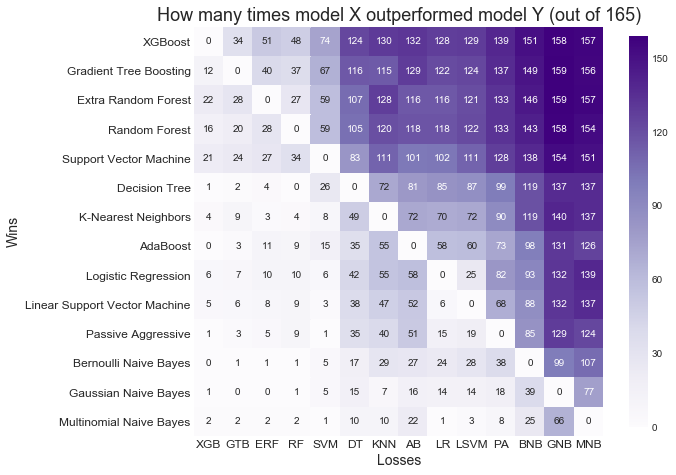

In [44]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
model_nice_dict = {
    'AdaBoostClassifier': 'AB',
    'BernoulliNB': 'BNB',
    'LogisticRegression': 'LR',
    'MultinomialNB': 'MNB',
    'PassiveAggressiveClassifier': 'PA',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'GNB',
    'DecisionTreeClassifier': 'DT',
    'ExtraTreesClassifier': 'ERF',
    'RandomForestClassifier': 'RF',
    'GradientBoostingClassifier':'GTB',
    'KNeighborsClassifier': 'KNN',
    'SVC': 'SVM',
    'XGBClassifier': 'XGB',
    'LinearSVC': 'LSVM'
}
model_nice_dict_y = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli Naive Bayes',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial Naive Bayes',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'Linear Model trained via\nStochastic Gradient Descent',
    'GaussianNB': 'Gaussian Naive Bayes',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Random Forest',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Tree Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbors',
    'SVC': 'Support Vector Machine',
    'XGBClassifier': 'XGBoost',
    'LinearSVC': 'Linear Support Vector Machine'
}

model_nice = []
model_nice_y = []
for m in all_models:
    model_nice.append(model_nice_dict[m])
    model_nice_y.append(model_nice_dict_y[m])
    
plt.figure(figsize=(10, 10))
sb.heatmap(model_tourney_matrix, square=True, annot=True, fmt='0.0f', cmap='Purples',
           xticklabels=model_nice, yticklabels=model_nice_y, cbar_kws={'shrink': 0.56})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Losses', fontsize=14)
plt.ylabel('Wins', fontsize=14)
plt.title('How many times model X outperformed model Y (out of 165)', fontsize=18)
h = plt.gcf()
plt.tight_layout()
#h.savefig('figs/model_outperformance.pdf', bbox_inches='tight')
#plt.savefig('figures/sklearn-model-x-outperform-model-y.pdf', bbox_inches='tight')
;

# How many models do we need to cover all data sets?

In [17]:
import pandas as pd
import pdb

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['dataset','classifier'])['accuracy'].max().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
data.head()

,dataset,classifier,accuracy
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,0.504
1,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,BernoulliNB,0.512
2,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,DecisionTreeClassifier,0.527
3,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,ExtraTreesClassifier,0.536
4,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,GaussianNB,0.501


In [18]:
from collections import defaultdict
from tqdm import tqdm
import numpy as np

dataset_best_models = defaultdict(list)
model_counts = defaultdict(int)

for dataset, group_dataset in data.groupby('dataset'):
    group_dataset['accuracy'] /= group_dataset['accuracy'].max()
    dataset_best_models[dataset] = group_dataset.loc[
        group_dataset['accuracy'] >= 0.99, 'classifier'].values

for dataset in dataset_best_models:
    for model in dataset_best_models[dataset]:
        model_counts[model] += 1
print('Model','&','Data Set Coverage','\\\\ \\hline')
for model in sorted(model_counts, key=model_counts.get, reverse=True):
    print(model,'&',model_counts[model],'\\\\')

/Users/randal_olson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Model & Data Set Coverage \\ \hline
XGBClassifier & 123 \\
GradientBoostingClassifier & 111 \\
ExtraTreesClassifier & 99 \\
RandomForestClassifier & 91 \\
SVC & 81 \\
DecisionTreeClassifier & 35 \\
LogisticRegression & 29 \\
LinearSVC & 28 \\
AdaBoostClassifier & 24 \\
KNeighborsClassifier & 20 \\
PassiveAggressiveClassifier & 15 \\
BernoulliNB & 8 \\
GaussianNB & 4 \\
MultinomialNB & 2 \\


In [19]:
dataset_best_models = defaultdict(list)
model_counts = defaultdict(int)

for dataset, group_dataset in data.groupby('dataset'):
    group_dataset['accuracy'] /= group_dataset['accuracy'].max()
    dataset_best_models[dataset] = group_dataset.loc[
        group_dataset['accuracy'] >= 0.99, 'classifier'].values

for dataset in dataset_best_models:
    for model in dataset_best_models[dataset]:
        model_counts[model] += 1

dataset_exclude_set = set()
top_models = []

while len(dataset_exclude_set) != len(data['dataset'].unique()):
    next_top_model = sorted(model_counts, key=model_counts.get, reverse=True)[0]
    top_models.append((model_counts[next_top_model], next_top_model))
    
    for dataset in dataset_best_models:
        if next_top_model in dataset_best_models[dataset]:
            dataset_exclude_set.add(dataset)

    dataset_best_models = defaultdict(list)
    model_counts = defaultdict(int)
    
    for dataset, group_dataset in data.groupby('dataset'):
        if dataset in dataset_exclude_set:
            continue
        group_dataset['accuracy'] /= group_dataset['accuracy'].max()
        dataset_best_models[dataset] = group_dataset.loc[
            group_dataset['accuracy'] >= 0.99, 'classifier'].values
        
    for dataset in dataset_best_models:
        for model in dataset_best_models[dataset]:
            model_counts[model] += 1

/Users/randal_olson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/randal_olson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
top_models

[(123, 'XGBClassifier'),
 (22, 'ExtraTreesClassifier'),
 (9, 'SVC'),
 (7, 'GradientBoostingClassifier'),
 (1, 'LinearSVC'),
 (1, 'RandomForestClassifier'),
 (1, 'KNeighborsClassifier')]

# How many model-parameter combinations do we need to cover all data sets?

In [21]:
import pandas as pd
import pdb

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['dataset','classifier','parameters'])['accuracy'].max().reset_index()

data['classifier-params'] = data['classifier'].values + '-' + data['parameters'].values
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))
data.head()

,dataset,classifier,parameters,accuracy,classifier-params
0,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=10,random_stat...",0.481,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
1,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=100,random_sta...",0.485,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
2,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=50,random_stat...",0.482,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
3,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.01,n_estimators=500,random_sta...",0.486,"AdaBoostClassifier-learning_rate=0.01,n_estima..."
4,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,AdaBoostClassifier,"learning_rate=0.1,n_estimators=10,random_state...",0.477,"AdaBoostClassifier-learning_rate=0.1,n_estimat..."


In [22]:
from collections import defaultdict 

dataset_best_models = defaultdict(list)
model_counts = defaultdict(int)

for dataset, group_dataset in data.groupby('dataset'):
    group_dataset.loc[:, 'accuracy'] = group_dataset['accuracy'].values / group_dataset['accuracy'].max()
    dataset_best_models[dataset] = group_dataset.loc[
        group_dataset['accuracy'] >= 0.99, 'classifier-params'].values

for dataset in dataset_best_models:
    for model in dataset_best_models[dataset]:
        model_counts[model] += 1

dataset_exclude_set = set()
top_models = []

while len(dataset_exclude_set) != len(data['dataset'].unique()):
    next_top_model = sorted(model_counts, key=model_counts.get, reverse=True)[0]
    top_models.append((model_counts[next_top_model], next_top_model))
    
    if len(top_models) == 10:
        break
    
    # Don't allow repeat models
    data = data.loc[data['classifier'] != next_top_model.split('-')[0].strip()]
    
    for dataset in dataset_best_models:
        if next_top_model in dataset_best_models[dataset]:
            dataset_exclude_set.add(dataset)

    dataset_best_models = defaultdict(list)
    model_counts = defaultdict(int)
    
    for dataset, group_dataset in data.groupby('dataset'):
        if dataset in dataset_exclude_set:
            continue
        group_dataset.loc[:, 'accuracy'] = group_dataset.loc[:, 'accuracy'].values / group_dataset['accuracy'].max()
        dataset_best_models[dataset] = group_dataset.loc[
            group_dataset['accuracy'] >= 0.99, 'classifier-params'].values
        
    for dataset in dataset_best_models:
        for model in dataset_best_models[dataset]:
            model_counts[model] += 1

/Users/randal_olson/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [24]:
top_models

[(55,
  'GradientBoostingClassifier-n_estimators=500,min_impurity_decrease=0.0,max_features=sqrt,learning_rate=0.1,loss=deviance,random_state=324089'),
 (13,
  'ExtraTreesClassifier-n_estimators=500,min_impurity_decrease=0.0,max_features=0.25,criterion=entropy,random_state=324089'),
 (8,
  'XGBClassifier-n_estimators=500,learning_rate=0.1,gamma=0.30000000000000004,max_depth=2,subsample=0.9,seed=324089,nthread=1'),
 (8,
  'LogisticRegression-C=1.5,penalty=l1,fit_intercept=True,dual=False,random_state=324089'),
 (7,
  'RandomForestClassifier-n_estimators=100,min_impurity_decrease=0.0,max_features=0.25,criterion=gini,random_state=324089'),
 (8,
  'SVC-C=0.1,gamma=0.5,kernel=poly,degree=2,coef0=50.0,random_state=324089'),
 (8,
  'LinearSVC-C=0.2,penalty=l1,fit_intercept=True,dual=False,random_state=324089'),
 (7, 'KNeighborsClassifier-n_neighbors=10,weights=distance'),
 (6,
  'AdaBoostClassifier-learning_rate=1.0,n_estimators=500,random_state=324089'),
 (8,
  'PassiveAggressiveClassifier-C

In [23]:
[(x, model_counts[x]) for x in sorted(model_counts, key=model_counts.get, reverse=True)[:25]]

[('PassiveAggressiveClassifier-C=0.01,loss=hinge,fit_intercept=True,random_state=324089',
  8),
 ('DecisionTreeClassifier-min_impurity_decrease=0.0075,max_features=None,criterion=entropy,random_state=324089',
  6),
 ('PassiveAggressiveClassifier-C=0.01,loss=squared_hinge,fit_intercept=True,random_state=324089',
  5),
 ('DecisionTreeClassifier-min_impurity_decrease=0.0,max_features=None,criterion=entropy,random_state=324089',
  5),
 ('DecisionTreeClassifier-min_impurity_decrease=0.01,max_features=None,criterion=entropy,random_state=324089',
  5),
 ('DecisionTreeClassifier-min_impurity_decrease=0.003,max_features=0.5,criterion=entropy,random_state=324089',
  4),
 ('DecisionTreeClassifier-min_impurity_decrease=0.00375,max_features=0.5,criterion=entropy,random_state=324089',
  4),
 ('DecisionTreeClassifier-min_impurity_decrease=0.0035,max_features=0.75,criterion=gini,random_state=324089',
  4),
 ('DecisionTreeClassifier-min_impurity_decrease=0.00475,max_features=None,criterion=entropy,rand

# Model/data biclustering analysis

Create matrix of data sets vs. best model accuracy on those data sets.

Cluster the matrix.





In [ ]:
import pandas as pd


data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset'])['bal_accuracy'].max().reset_index()
# print("classifiers before drop:",data['classifier'].unique())
# data = data[data['classifier']!='LinearSVC']
# data = data[data['classifier']!='SVC']
print('loaded ',data['dataset'].unique().shape[0],'datasets and ', data['classifier'].unique().shape[0],'classifiers')
# data['classifier-params'] = data['classifier'].values + '-' + data['parameters'].values
data['bal_accuracy'] = data['bal_accuracy'].apply(lambda x: round(x, 3))

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score
import matplotlib.pyplot as plt
%matplotlib inline
import pdb
# get model results with best parameters 

all_models = np.asarray((data['classifier'].unique()))
all_datasets = np.asarray((data['dataset'].unique()))
model_data_acc = np.zeros([len(all_models),len(all_datasets)])
model_data_acc_norm = np.zeros([len(all_models),len(all_datasets)])

ranks = np.zeros([len(all_models),len(all_datasets)])
#print("model_data_acc.shape:",model_data_acc.shape)
# all_models = []
for i,(clf, group_clf) in enumerate(tqdm(data.groupby('dataset'))):
    print('clf:',clf)
    data_acc  = group_clf['bal_accuracy'].transpose()
    model_data_acc[:,i] = data_acc
#     model_data_acc_norm[:,i] = (data_acc-data_acc.min())/(data_acc.max() - data_acc.min())
    model_data_acc_norm[:,i] = (data_acc-data_acc.mean())

#     all_models.append(clf)
    
all_models = np.asarray(all_models)
# get ranks
for i,mda in enumerate(model_data_acc.transpose()):
    #print("mda shape:",mda.shape)
    temp = mda.argsort()
    ranks[temp,i] = np.arange(len(mda))
np.savetxt('figs/ranks',ranks)
np.savetxt('figs/model_data_accuracy',model_data_acc)


print("clustering...")
np.random.seed(42)
model = SpectralBiclustering(n_clusters=(4,10), random_state=0)
model.fit(model_data_acc)
#score = consensus_score(model.biclusters_, (rows[:, row_idx], columns[:, col_idx]))

#print("consensus score: {:.3f}".format(score))
r = model.row_labels_[:]
c = model.column_labels_[:]
#rearrange data into biclusters
fit_data_norm = model_data_acc_norm[np.argsort(r)]
fit_data_norm = fit_data_norm[:, np.argsort(c)]

fit_data = model_data_acc[np.argsort(r)]
fit_data = fit_data[:, np.argsort(c)]

all_models = all_models[np.argsort(r)]
all_datasets = all_datasets[np.argsort(c)]
print('done')

In [ ]:
model_nice_dict = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli NB',
    'LinearSVC': 'Linear SVC',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial NB',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'Gaussian NB',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Trees',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbor',
    'SVC': 'SVC',
    'XGBClassifier': 'XGBoost',
    'LinearSVC': 'Linear Support Vector Machine'
}
model_nice = []
for m in all_models:
    model_nice.append(model_nice_dict[m])
    
    
print("biclusters_:",len(model.biclusters_))
#plot
# h = plt.figure(figsize=(4,3),sharey=True)
# ax = plt.subplot(111)
h,ax = plt.subplots(3,figsize=(10,9))
# ax = h.add_subplot(311)
tmp = ax[0].imshow(fit_data[:,:],cmap=plt.cm.RdBu) 
# ax[0].set_title('A')
# ax[0].set_xlabel('A')
cbar=plt.colorbar(tmp,ax=ax[0],orientation='vertical',shrink=0.8)
cbar.set_label('Balanced Accuracy')
ax[0].set_yticks(range(len(all_models))) #,rotation=90
ax[0].set_yticklabels(model_nice) #,rotation=90
# ax[1].set_xlabel('Data Set',size=16)
ax[0].set_xticks(np.arange(len(all_datasets),step=10))
ax[0].xaxis.tick_top()

# h = plt.gcf()
# ax = plt.gca( )
ax[0].set_aspect(4)

# h.tight_layout()
# h = plt.gcf()

# h.savefig("figs/bicluster.pdf",dpi=100)

# k = plt.figure(figsize=(10,3))
# ax = h.add_subplot(312)
tmp = ax[1].matshow(fit_data_norm[:,:],cmap=plt.cm.RdBu) 

cbar=plt.colorbar(tmp,ax=ax[1],orientation='vertical',shrink=0.8)
cbar.set_label('Deviation from Mean')
ax[1].set_yticks(range(len(all_models))) #,rotation=90
ax[1].set_yticklabels(model_nice) #,rotation=90
# ax[1].set_xlabel('Data Set',size=16)
ax[1].set_xticks(np.arange(len(all_datasets),step=10))
# ax[1].set_xlabel('B')
# h = plt.gcf()
# ax = plt.gca( )
ax[1].set_aspect(4)
# h.tight_layout()
# h = plt.gcf()

# k.savefig("figs/bicluster_zeromean.pdf",dpi=100)


# h2 = plt.figure(figsize=(10,3))
# ax = h.add_subplot(313)
cluster_labels  = np.outer(np.sort(model.row_labels_) + 1,np.sort(model.column_labels_) + 1)
boundary = np.zeros((cluster_labels.shape[0],cluster_labels.shape[1]))
for i,cr in enumerate(cluster_labels[1:]):
    for j,cc in enumerate(cr[1:]):
        if cluster_labels[i-1,j] != cluster_labels[i,j]:
            boundary[i,j] = 1
        if cluster_labels[i,j-1] != cluster_labels[i,j]:
            boundary[i,j] = 1
            
tmp=ax[2].matshow(cluster_labels,cmap=plt.cm.Purples,alpha=1)
# tmp = 
# ydata = [0,165,0,165,0,165]
# tmp=ax[2].plot((0,165),(2.5,2.5))
# plt.gca().invert_yaxis()
cbar=plt.colorbar(tmp,ax=ax[2],orientation='vertical',shrink=0.8)
cbar.set_label('Bicluster ID')
plt.yticks(range(len(all_models)), model_nice) #,rotation=90
ax[2].set_xlabel('Dataset',size=16)
plt.xticks(np.arange(len(all_datasets),step=10))
# ax[2].set_xlabel('C')
# h = plt.gcf()
# ax = plt.gca( )
ax[2].set_aspect(4)
h.tight_layout()
# plt.subplots_adjust(top=0.95)
#h.savefig("figs/cluster_all.pdf",dpi=100)
#h.savefig("figs/cluster_all.eps",dpi=100)
#h.savefig("figs/cluster_all.png",dpi=100)


plt.show()
j=0
for c in np.unique(cluster_labels[0,:]):
    print('cluster',c,':')
    for d in all_datasets[cluster_labels[0,:]==c]:
#         print('',j,":",d)
        print('"'+d+'"',end=',')
        j+=1
    print(' ')

# How do the algorithms cluster?

Create matrix of data sets vs. median model accuracy on those data sets.

Cluster the matrix using Agglomerative Clustering. Look at the resulting dendrogram.

In [ ]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

# data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
%matplotlib inline

all_models = np.asarray(sorted(data['classifier'].unique()))
# remove SVC from all_models

all_datasets = np.asarray(sorted(data['dataset'].unique()))

model_data_acc = np.zeros([len(all_models),len(all_datasets)])
ranks = np.zeros([len(all_models),len(all_datasets)])
#print("model_data_acc.shape:",model_data_acc.shape)
all_models = []

for i,(clf, group_clf) in enumerate(tqdm(data.groupby('classifier'))):
#     if clf != 'SVC':
    model_best_params_acc = np.zeros(len(all_datasets))
    # find best parameter setings for model, based on median cv score for each parameter setting
    for params,group_clf_params in group_clf.groupby('parameters'):
        # across data sets
        for j,a in enumerate(group_clf_params.groupby('dataset')['accuracy'].median()):
            if a > model_best_params_acc[j]:
                model_best_params_acc[j] = a
    # model i's accuracy is the median cv accuracy of the best parameter settings for that model, across data sets
    model_data_acc[i,:] = model_best_params_acc

    all_models.append(clf)

all_models = np.asarray(all_models)

# get ranks
for i,mda in enumerate(model_data_acc.transpose()):
    #print("mda shape:",mda.shape)
    temp = mda.argsort()
    ranks[temp,i] = np.arange(len(mda))
    


In [ ]:
model_nice_dict = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli NB',
    'LinearSVC': 'Linear SVC',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial NB',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'Gaussian NB',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Trees',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbor',
    'SVC': 'SVC',
    'XGBClassifier': 'XGBoost',
    'LinearSVC': 'Linear Support Vector Machine'
}
model_nice = []
for m in all_models:
    model_nice.append(model_nice_dict[m])
    
print("clustering...")
Z = hierarchy.linkage(ranks, 'single')
dn = hierarchy.dendrogram(Z, labels = model_nice, orientation='right')
plt.title('Ranking Dendrogram')
h = plt.gcf()
plt.figure(1,figsize=(6,4))
plt.tight_layout()
#h.savefig('figs/HAC_models_ranking.pdf')

plt.figure()
Z = hierarchy.linkage(model_data_acc, 'single')
dn = hierarchy.dendrogram(Z, labels = model_nice, orientation='right')
plt.title('Accuracy Dendrogram')
h = plt.gcf()
plt.figure(1,figsize=(6,4))
plt.tight_layout()
#h.savefig('figs/HAC_models_accuracy.pdf')
plt.show()

# How do the data sets cluster?

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import numpy
from tqdm import tqdm
#==========
# optimal K via elbow method with silhouette score which produces a better elbow.
#==========
X = model_data_acc.transpose()
Ks = np.arange(2,147,1)
Inertias = []
Silhouettes = []
np.random.seed(2)
# loop through k values
for K in tqdm(Ks):
    km = KMeans(n_clusters=K, init='k-means++',copy_x=False).fit(X)
    labels = km.labels_
    centers = km.cluster_centers_
    inertia = km.inertia_
    Silhouettes.append(silhouette_score(X,labels))
    # Inertias[K-1] = km.inertia_
    Inertias.append(km.inertia_)

# line plot of K versus Silhouette score with best value marked with x 
plt.figure(1)
plt.plot(Ks,Silhouettes,label='silhouette')
plt.plot(Ks[np.argmax(Silhouettes)],Silhouettes[np.argmax(Silhouettes)],marker = 'o',color='r',markersize=7)
plt.text(Ks[np.argmax(Silhouettes)]-2,Silhouettes[np.argmax(Silhouettes)],"K = "+repr(Ks[np.argmax(Silhouettes)]))
plt.ylim(0.95*np.min(Silhouettes),1.05*np.max(Silhouettes))
plt.ylabel("Average silhouette score") #Y-axis label
plt.xlabel("K") #X-axis label
plt.title("Choice of K") #Plot title
plt.tight_layout()
plt.savefig("figs/k_silhouette.pdf")

plt.figure(2)
plt.plot(Ks,Inertias,label='inertia')
plt.plot(Ks[np.argmin(Inertias)],Inertias[np.argmin(Inertias)],marker = 'o',color='r',markersize=7)
plt.text(Ks[np.argmin(Inertias)]-2,Inertias[np.argmin(Inertias)],"K = "+repr(Ks[np.argmin(Inertias)]))
plt.ylim(0.95*np.min(Inertias),1.05*np.max(Inertias))
plt.ylabel("Inertias") #Y-axis label
plt.xlabel("K") #X-axis label
plt.title("Choice of K") #Plot title
plt.tight_layout()
plt.savefig("figs/k_inertia.pdf")

In [ ]:
# =====
# plot cluster centers on 2 principal component axes
# =====
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import StandardScaler

marker =('+', 'x', 'o', '*','s','^','<','v','>') 
h = plt.figure()
ss = StandardScaler()
X = ss.fit_transform(model_data_acc.transpose())

pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
nc=4
unique_classes = np.array((0,1,2,3)) 
km = KMeans(n_clusters=nc, init='k-means++',copy_x=False,random_state=0).fit(X)
labels = km.labels_
centers = km.cluster_centers_
unique_labels = np.unique(labels)
# centers_pca = centers
centers_pca = pca.transform(centers)
colors = plt.cm.Dark2(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    label_mask = (k==labels)
    xy = X_pca[label_mask]
    plt.plot(xy[:,0], xy[:, 1], linestyle = '', marker=marker[k%nc], markerfacecolor=col, markersize=5, alpha=1)

for k, col in zip(unique_labels, colors): 
     plt.plot(centers_pca[k,0],centers_pca[k,1], linestyle='', marker=marker[k%nc], markerfacecolor=col,markersize=20,alpha=0.3)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.tight_layout()
h.savefig('figs/k_means_PCA_data.pdf')

h2 = plt.figure()
features = model_nice
    
for k,col in zip(unique_labels,colors):
    label_mask = (k==labels)
    coverage = np.sum(label_mask)
    xk_mean = np.mean(ss.inverse_transform(X[label_mask]),axis=0)
    offset = k*0.1-np.mean(np.unique(labels))*0.1
    print('col:',col)
    plt.bar(np.arange(len(features))+offset,xk_mean,align='center',width=0.1,facecolor=col,label='cluster '+marker[k%nc]+' ('+str(coverage)+' instances)')

plt.ylim(0,1.1)
plt.gca().set_xticks(np.arange(len(features)))
plt.gca().set_xticklabels(list(features),fontsize=8,rotation=90)
plt.legend(loc=3,fontsize=6) #(bbox_to_anchor=(1.05, 1), 
plt.tight_layout()
h2.savefig('figs/data_ml_bar.pdf')

plt.show()

# Comparison of tuned to un-tuned results


In [25]:
import numpy as np
from tqdm import tqdm
import pandas as pd

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')

data = data.groupby(['classifier', 'dataset', 'parameters'])['accuracy'].mean().reset_index()
data['accuracy'] = data['accuracy'].apply(lambda x: round(x, 3))

In [26]:
clf_defaults_dict = {
    'GradientBoostingClassifier': 'n_estimators=100,min_impurity_decrease=0.0,max_features=None,learning_rate=0.1,loss=deviance,random_state=324089',
    'RandomForestClassifier': 'n_estimators=10,min_impurity_decrease=0.0,max_features=sqrt,criterion=gini,random_state=324089',
    'SVC': 'C=1.0,gamma=auto,kernel=rbf,degree=2,coef0=0.0,random_state=324089',
    'ExtraTreesClassifier': 'n_estimators=10,min_impurity_decrease=0.0,max_features=sqrt,criterion=gini,random_state=324089',
    'KNeighborsClassifier': 'n_neighbors=5,weights=uniform',
    'LogisticRegression': 'C=1.0,penalty=l2,fit_intercept=True,dual=False,random_state=324089',
    'DecisionTreeClassifier': 'min_impurity_decrease=0.0,max_features=None,criterion=gini,random_state=324089',
    'PassiveAggressiveClassifier': 'C=1.0,loss=hinge,fit_intercept=False,random_state=324089',
    'AdaBoostClassifier': 'learning_rate=1.0,n_estimators=50,random_state=324089',
    'BernoulliNB': 'alpha=1.0,fit_prior=True,binarize=0.0',
    'GaussianNB': '',
    'MultinomialNB': 'alpha=1.0,fit_prior=True',
    'XGBClassifier': 'n_estimators=100,learning_rate=0.1,gamma=0.0,max_depth=3,subsample=1.0,seed=324089,nthread=1',
    'LinearSVC': 'C=1.0,penalty=l2,fit_intercept=True,dual=True,random_state=324089'
}

default_params_list = ['-'.join([k, v]) for k, v in clf_defaults_dict.items()]

default_scores = data.loc[
    data.apply(
        lambda record: '-'.join([record['classifier'],
                                 record['parameters']]) in default_params_list,
        axis=1)].drop('parameters', axis=1)

best_scores = data.groupby(['dataset', 'classifier'])['accuracy'].max().reset_index()

In [27]:
merged_scores = default_scores.merge(best_scores,
                                     on=['classifier', 'dataset'],
                                     suffixes=['_default', '_best'])

merged_scores['accuracy_default_scaled'] = merged_scores['accuracy_best'] - merged_scores['accuracy_default']

model_names_dict = {
    'AdaBoostClassifier': 'AdaBoost',
    'BernoulliNB': 'Bernoulli Naive Bayes',
    'LogisticRegression': 'Logistic Regression',
    'MultinomialNB': 'Multinomial Naive Bayes',
    'PassiveAggressiveClassifier': 'Passive Aggressive',
    'GaussianNB': 'Gaussian Naive Bayes',
    'DecisionTreeClassifier': 'Decision Tree',
    'ExtraTreesClassifier': 'Extra Random Forest',
    'RandomForestClassifier': 'Random Forest',
    'GradientBoostingClassifier':'Gradient Tree Boosting',
    'KNeighborsClassifier': 'K-Nearest Neighbors',
    'SVC': 'Support Vector Machine',
    'XGBClassifier': 'XGBoost',
    'LinearSVC': 'Linear Support Vector Machine'
}

merged_scores['classifier'] = merged_scores['classifier'].apply(lambda x: model_names_dict[x])

merged_scores.head()

,classifier,dataset,accuracy_default,accuracy_best,accuracy_default_scaled
0,AdaBoost,GAMETES_Epistasis_2-Way_1000atts_0.4H_EDM-1_ED...,0.477,0.504,0.027
1,AdaBoost,GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1,0.496,0.515,0.019
2,AdaBoost,GAMETES_Epistasis_2-Way_20atts_0.4H_EDM-1_1,0.474,0.500,0.026
3,AdaBoost,GAMETES_Epistasis_3-Way_20atts_0.2H_EDM-1_1,0.526,0.532,0.006
4,AdaBoost,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,0.477,0.510,0.033


''

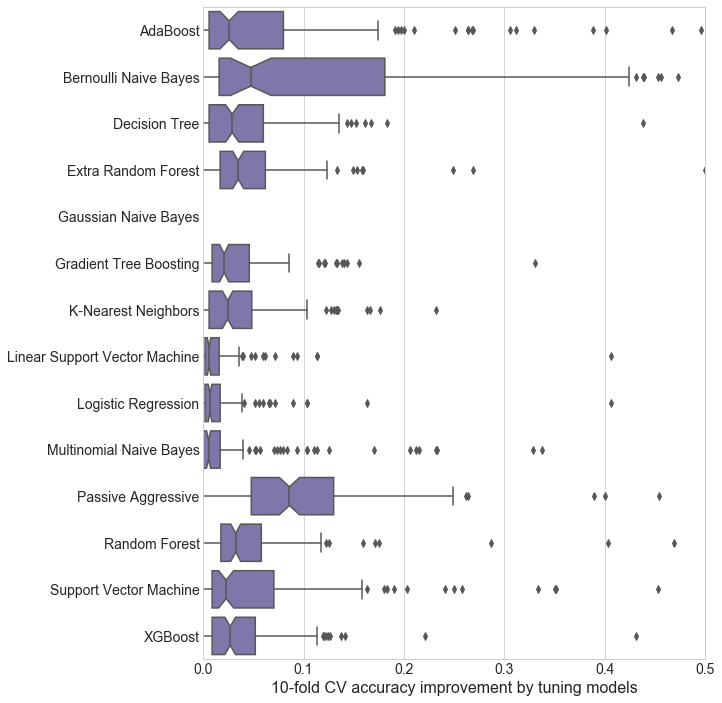

In [28]:
%matplotlib inline
import seaborn as sb
import matplotlib.pyplot as plt

sb.set_style('whitegrid')

plt.figure(figsize=(9, 12))
sb.boxplot(data=merged_scores.sort_values('classifier'),
           y='classifier', x='accuracy_default_scaled', notch=True,
           palette=[sb.color_palette('Purples', n_colors=2)[1]])
plt.ylabel('')
plt.xlabel('10-fold CV accuracy improvement by tuning models', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0., 0.5)
#plt.title('Tuning machine learning model parameters almost always improves\nmodel performance', fontsize=22)
#plt.savefig('figs/tuned_untuned_accuracy_boxplot.pdf', bbox_inches='tight')
;

# print model abbreviation table

In [ ]:
model_nice_dict = {
    'AdaBoostClassifier': 'AB',
    'BernoulliNB': 'BNB',
    'LinearSVC': 'LSVC',
    'LogisticRegression': 'LR',
    'MultinomialNB': 'MNB',
    'PassiveAggressiveClassifier': 'PAC',
    'SGDClassifier': 'SGD',
    'GaussianNB': 'GNB',
    'DecisionTreeClassifier': 'DT',
    'ExtraTreesClassifier': 'ET',
    'RandomForestClassifier': 'RF',
    'GradientBoostingClassifier':'GB',
    'KNeighborsClassifier': 'KNN',
    'XGBClassifier': 'XGBoost',
    'LinearSVC': 'Linear Support Vector Machine'
}
model_nice = []
for m in model_nice_dict:
    print(model_nice_dict)


    

In [ ]:
import pandas as pd

data = pd.read_csv('sklearn-benchmark6-data.tsv.gz', sep='\t', names=['dataset',
                                                                     'classifier',
                                                                     'parameters',
                                                                     'accuracy', 
                                                                     'macrof1',
                                                                     'bal_accuracy']).fillna('')
data = data.groupby(['dataset','classifier'])['bal_accuracy'].max().reset_index()

print(data[:5])

In [ ]:
import seaborn as sns

datan = data.groupby(['dataset']).max().sort_values('bal_accuracy',ascending=False)
# print(datan)

datamv = data.groupby(['dataset']).median()+data.groupby(['dataset']).var()
datamv = datamv.sort_values('bal_accuracy',ascending=True)

# for i in datamv.index:
#     print(data[i,'bal_accuracy'])
print(datamv[::2])
# print(datan.index)

print(data['dataset'][:5])
plt.figure(figsize=(10,5))
sns.set_style("whitegrid")
s=sns.boxplot(data=data,x='dataset',y='bal_accuracy',order=datan.index,fliersize=3,linewidth=0.75)
s.set_xticks(np.arange(len(np.unique(data['dataset'])),step=10))
s.set_xticklabels(np.arange(len(np.unique(data['dataset'])),step=10))
yticks = np.hstack((np.arange(0.6,step=0.1),np.arange(0.6,1.05,step=0.05)))
s.set_yticks(yticks)
s.set_yticklabels(['{0:.2f}'.format(x) for x in yticks],size=9)
plt.ylim(0,1.1)
plt.ylabel('Balanced Accuracy',size=16)
plt.xlabel('Dataset',size=16)
h = plt.gcf()
h.tight_layout()
#h.savefig('figs/boxplot_all.pdf',bbox_inches='tight')
#h.savefig('figs/boxplot_all.png',bbox_inches='tight')


print('90% cutoff:',len(datan[datan['bal_accuracy']>=0.9]))
print('80% cutoff:',len(datan[datan['bal_accuracy']>=0.8]))
print('70% cutoff:',len(datan[datan['bal_accuracy']>=0.7]))
print('60% cutoff:',len(datan[datan['bal_accuracy']>=0.6]))

# for i,d in enumerate(datan.index):

#     print('data set ',i,':',data['dataset'][d])
# plt.gca().set_xticks(np.arange(len(data),step=10))
# plt.gca().set_xticklabels(str(np.arange(len(data),step=10)))

In [ ]:
cutoff = np.empty(100)
for i in np.arange(100):
    cutoff[i] = len(datan[datan['bal_accuracy']>=i/100])/len(datan)
plt.bar(np.arange(len(cutoff)),cutoff)
plt.xlim(50,100)
plt.show()

In [ ]:
149./165